In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# setting style
sns.set_style('darkgrid')
%matplotlib inline

# About the drug200 dataset   

Target Variable:  

* 'Drug' - the type drug to be administered to a patient  

Features:  

* 'Age' - the age of the patient  
* 'Sex' - the gender of the patient  
* 'BP' - the blood pressure of the patient  
* 'Cholesterol' - the level of cholesterol in a patient  
* 'Na_to_K' - the amount of sodium to potassium in blood stream   


### The goal is to build an effective decision tree classification algorithm that can accurately calculate the correct drug to administer patients. The model is prone to overfitting and thus the critical evaulation metric would be the training and testing accuracies.

In [3]:
# csv url 
csv_url = 'https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/drug200.csv'

# reading csv file into pandas dataframe
df = pd.read_csv(csv_url)
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


# Data Preprocessing

In [4]:
# shape of dataset
df.shape

(200, 6)

In [5]:
# information about dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
Age            200 non-null int64
Sex            200 non-null object
BP             200 non-null object
Cholesterol    200 non-null object
Na_to_K        200 non-null float64
Drug           200 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [6]:
# identifying missing values
df.isna().sum()

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

In [7]:
df.dtypes

Age              int64
Sex             object
BP              object
Cholesterol     object
Na_to_K        float64
Drug            object
dtype: object

#### Encoding categorical variables using the one-hot-encoding method (LabelEncoder( ))

In [8]:
print('Sex: ', df['Sex'].unique())
print('BloodPressure: ', df['BP'].unique())
print('Cholesterol: ', df['Cholesterol'].unique())

Sex:  ['F' 'M']
BloodPressure:  ['HIGH' 'LOW' 'NORMAL']
Cholesterol:  ['HIGH' 'NORMAL']


In [9]:
# importing necessary libraries
from sklearn.preprocessing import LabelEncoder
# deep copy dataframe
new_df = df.copy(deep=True)
new_df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


In [10]:
# deep copy dataframe
new_df = df.copy(deep=True)

# label encoder object
label = LabelEncoder()

# encoding sex 
label_sex = label.fit(['M', 'F'])
new_df['Sex'] = label_sex.transform(new_df['Sex'])

# encoding blood pressure
label_bp = label.fit(['LOW', 'NORMAL', 'HIGH'])
new_df['BP'] = label.fit_transform(new_df['BP'])

# encoding cholesterol
label_chol = label.fit(['NORMAL', 'HIGH'])
new_df['Cholesterol'] = label_chol.transform(new_df['Cholesterol'])

new_df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,0,0,0,25.355,drugY
1,47,1,1,0,13.093,drugC
2,47,1,1,0,10.114,drugC
3,28,0,2,0,7.798,drugX
4,61,0,1,0,18.043,drugY


# Exploratory Data Analysis

### Sex and age

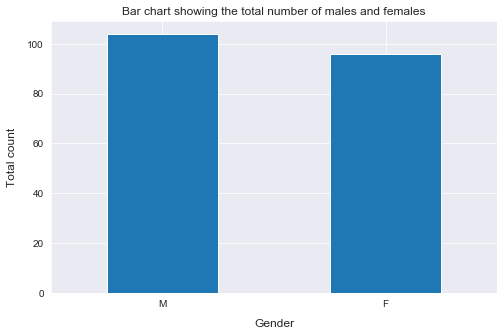

Males account for:  52.0 % of the patients
Females account for:  48.0 % of the patients
The average age of patients:  44


In [11]:
# bar plot showing the total number of male and female patients
ax1 = df['Sex'].value_counts().plot(kind='bar',
                                figsize=(8, 5),
                                title='Bar chart showing the total number of males and females',
                                rot=0,
                                fontsize=10)

ax1.set_xlabel('Gender', labelpad=10, size=12)
ax1.set_ylabel('Total count', labelpad=10, size=12)
plt.show()

# average age of data
age = int(df['Age'].mean())

# porportions of each gender in the dataset
males, females = df['Sex'].value_counts(normalize=True) * 100

print('Males account for: ' , males,'% of the patients')
print('Females account for: ' , females , '% of the patients')
print('The average age of patients: ', age)

### Cholesterol 

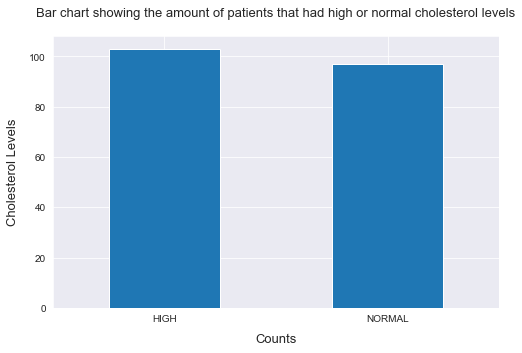

In [12]:
# bar chart showing value counts of cholesterol
ax1 = df['Cholesterol'].value_counts().plot(kind='bar',
                                       figsize=(8,5),
                                       fontsize=10,
                                       rot=0)
ax1.set_xlabel('Counts', fontsize=13, labelpad=10)
ax1.set_ylabel('Cholesterol Levels', size=13, labelpad=10)
ax1.set_title('Bar chart showing the amount of patients that had high or normal cholesterol levels', 
              pad=20, 
              size=13)
plt.show()

### Target Variable - Drug to be administered

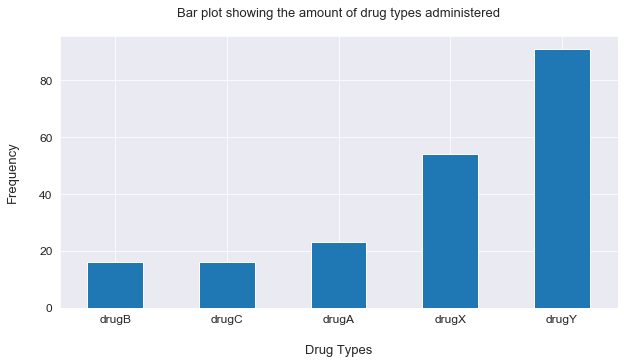

drugY    45.5
drugX    27.0
drugA    11.5
drugC     8.0
drugB     8.0
Name: Drug, dtype: float64%


In [24]:
ax1 = new_df['Drug'].value_counts().sort_values().plot(kind='bar',
                                                      fontsize=12,
                                                      rot=0,
                                                      figsize=(10,5))
ax1.set_title('Bar plot showing the amount of drug types administered', size=13, pad=20)
ax1.set_xlabel('Drug Types', size=13, labelpad=20)
ax1.set_ylabel('Frequency', size=13, labelpad=20)
plt.show()

print('The proportion of drugs frequently administered to patients')
print(str(new_df['Drug'].value_counts(normalize=True).sort_values(ascending=False) * 100))

#### *DrugY seem to have been administered the most frequently, while 'drugC' and 'drugB' have been administered the least amount of times* 

# Building the Model

In [25]:
# import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
# import evaluation metrics
from sklearn.metrics import f1_score, precision_score, recall_score

### Feature Selection

In [27]:
# features/independent variables
X = new_df.drop(columns=['Drug'])
# target variable
Y = new_df['Drug']

print(X.shape)
print(Y.shape)

(200, 5)
(200,)


### Splitting data into test and training sets

In [163]:
# using scikit-learns train_test_split function to split data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=3)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(140, 5) (140,)
(60, 5) (60,)


### Decision Tree Classifier

In [217]:
# tree objected fitted training sets
tree = DecisionTreeClassifier(criterion='entropy').fit(x_train, y_train)

# estimations
yhat = tree.predict(x_test)

# dataframe to compare differences
test_pred = pd.DataFrame({'True': y_test,
                         'Predicted': yhat})

test_pred.reset_index(drop=True).head()

,True,Predicted
0,drugY,drugY
1,drugX,drugX
2,drugX,drugX
3,drugX,drugX
4,drugX,drugX


### Evaluation Metrics

In [220]:
# training set accuracy
train_acc = tree.score(x_train, y_train)
# test set accuracy
test_acc = tree.score(x_test, y_test)

print('Trainign accuracy: \t', train_acc)
print('Testing accuracy:  \t', test_acc)

Trainign accuracy: 	 1.0
Testing accuracy:  	 0.9833333333333333


### Results on initial model   

* The model is completely overfitting the training data. The models complexity can be changed by finding the optimum paramters.* 

### Finding Optimum Parameters     

In [169]:
### Finding the maximum number of leaf nodes that optimizes the testing score
for i in [2,3,4,5,6,7]:
    tree = DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=i).fit(x_train, y_train)
    yhat = tree.predict(x_test)
    print(i, '\tTest Score:', tree.score(x_test, y_test))
    print('\tTraining Score:', tree.score(x_train, y_train), '\n')

2 	Test Score: 0.7
	Training Score: 0.7285714285714285 

3 	Test Score: 0.8166666666666667
	Training Score: 0.8428571428571429 

4 	Test Score: 0.9
	Training Score: 0.9214285714285714 

5 	Test Score: 0.8166666666666667
	Training Score: 0.9285714285714286 

6 	Test Score: 0.9833333333333333
	Training Score: 1.0 

7 	Test Score: 0.9833333333333333
	Training Score: 1.0 



#### Results on leaf nodes:  

Model is optimized and fits the data well when max_leaf_nodes=4.  
Scores:  

* Test Score: 0.9
* Training Score: 0.9214 

In [221]:
### Finding the max depth that optimizes the testing score
for i in [2,3,4,5]:
    tree = DecisionTreeClassifier(criterion='entropy', max_depth=i).fit(x_train, y_train)
    yhat = tree.predict(x_test)
    print(i, '\tTest Score:', tree.score(x_test, y_test))
    print('\tTraining Score:', tree.score(x_train, y_train), '\n')

2 	Test Score: 0.8166666666666667
	Training Score: 0.8428571428571429 

3 	Test Score: 0.8166666666666667
	Training Score: 0.9285714285714286 

4 	Test Score: 0.9833333333333333
	Training Score: 1.0 

5 	Test Score: 0.9833333333333333
	Training Score: 1.0 



#### Results on leaf nodes:  

The max_depth parameter seems too broad of a way to reduce the overfitting of the model. When max_depth is 4 or 5, the training accuracy is a perfect score of 1, while its test score is 0.98. The optimum paramter here would be when max_depth=2, since its test_score and training_score are similar. 

Scores:  

* Test Score: 0.8166
* Training Score: 0.8428

### Building Final Model

In [223]:
# tree object 
tree = DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=4).fit(x_train, y_train)
# estimations
yhat = tree.predict(x_test)

# evaluations
# training set accuracy
train_acc = tree.score(x_train, y_train)
# test set accuracy
test_acc = tree.score(x_test, y_test)

print('Trainign accuracy: \t', train_acc)
print('Testing accuracy:  \t', test_acc)

Trainign accuracy: 	 0.9214285714285714
Testing accuracy:  	 0.9


### Plotting Tree

In [200]:
# importing necessary libraries
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

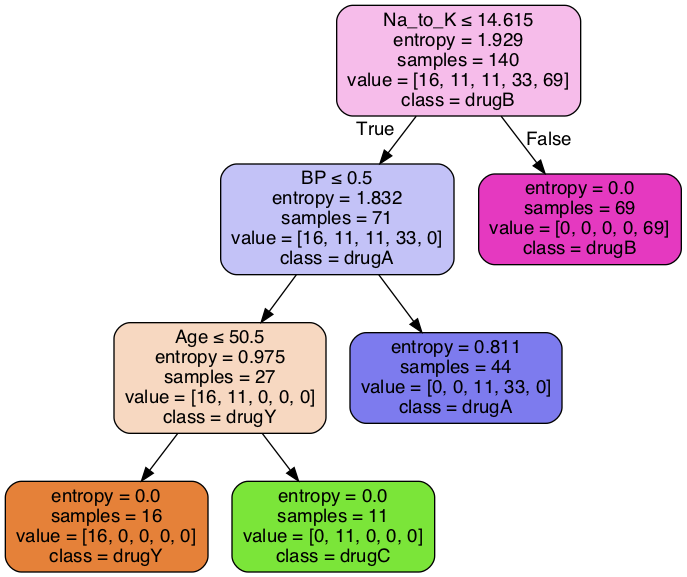

In [211]:
# dot data
dot_data = StringIO()

# features
features = df.columns[:5]
# target
target = df['Drug'].unique().tolist()

# using export_graphviz from scikit learns tree library
export_graphviz(tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, 
                class_names=target,
                feature_names=features)

# creating graph
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#showing image
Image(graph.create_png())

### Conclusion on Models Performance  

* The model performs optimally when the maximum number of leaf nodes is 4. The model has a test accuracy of 90% and a training accuracy of 92%. The model also statisfies all the inital requirements, however, a different classification algorithm can be used to optimize the model even further.